# Прогнозирование вероятности оттока пользователей для фитнес-центров

## Описание проекта

Цель данного проекта — провести анализ и подготовить план действий по удержанию клиентов сети фитнес центра.

А именно: 
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    1. выделить целевые группы клиентов;
    2.предложить меры по снижению оттока;
    3. определить другие особенности взаимодействия с клиентами.




## Описание данных

- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.

## Загрузка данных

In [1]:
# импорт необходимых библиотек
import pandas as pd 
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, plot_roc_curve
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

In [2]:
# загрузим датасет 
df = pd.read_csv('/datasets/gym_churn.csv')

## EDA

In [3]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
df.duplicated().sum()

0

Видим, что датасет содержит 12 признаков и бинарную целевую переменную Churn. Пропусков в датасете нет. Строк дубликтов нет. 

In [6]:
# Выведем описательную статистику методом describe
df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [7]:
# посчитаем долю классов для целевой переменной  
df.Churn.value_counts()/df.shape[0]

0    0.73475
1    0.26525
Name: Churn, dtype: float64

Видим, что классы несколько несбалансированны (соотношение классов примерно 1:3)

In [8]:
# Посмотрим на средние значения признаков в двух группах 
df.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Видим, что по средним значениями некоторых признакам группы целевой переменной неплохо различаются. Так, например, средний Lifetime для класса 0 - 4.71, а для класса 1 - 0.99

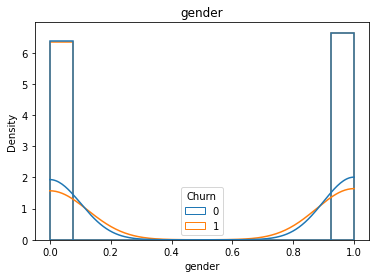

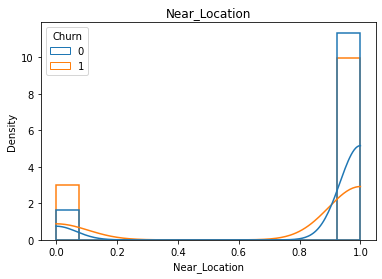

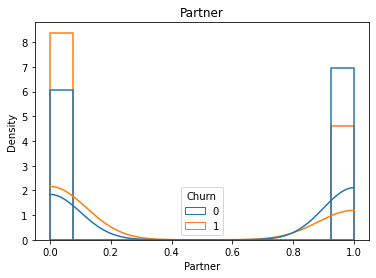

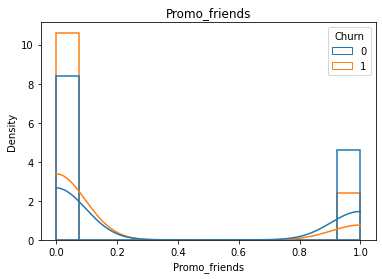

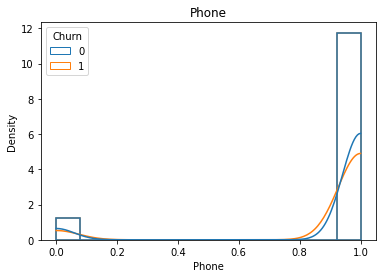

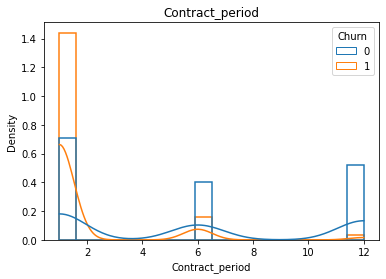

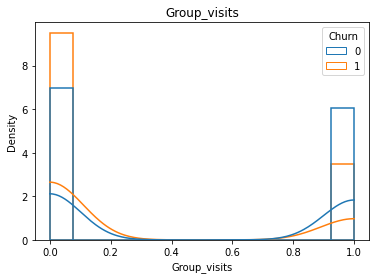

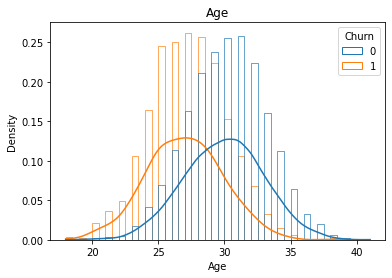

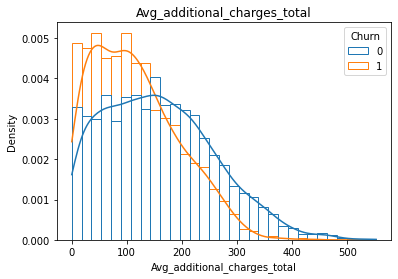

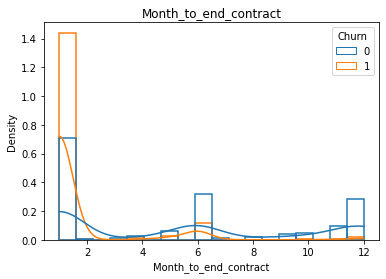

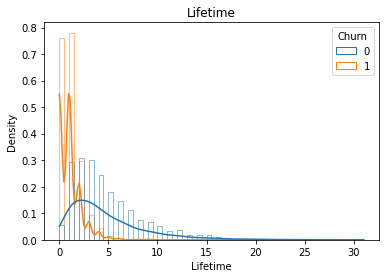

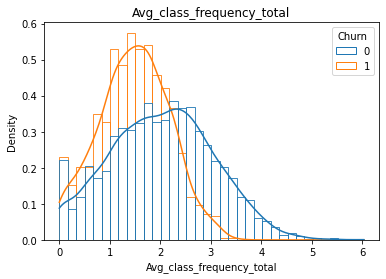

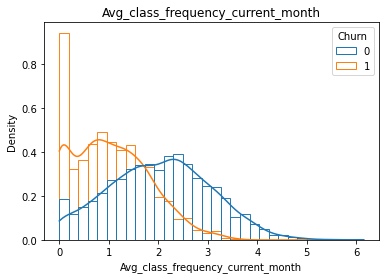

In [9]:
# Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);
for col in df.columns.drop('Churn'):
    sns.histplot(df,
            x=col, 
            hue = 'Churn', 
            kde = True, 
            stat="density", 
            fill=False, 
            common_norm=False
    )
    plt.title(col)
    plt.show()


По гистограммам видим аналогичную картину, как и со средними значениями - по некоторым непрерывным признакам наблюдается неплохое разделения между модальными значениями гистограмм для классов 1 и 0. Наилучшее разделение наблюдаем по параметрам Age, Avg_class_frequency_total и lifetime. Вероятно данные признаки и будут оказывать ключевое влияние на решение задачи классификации.

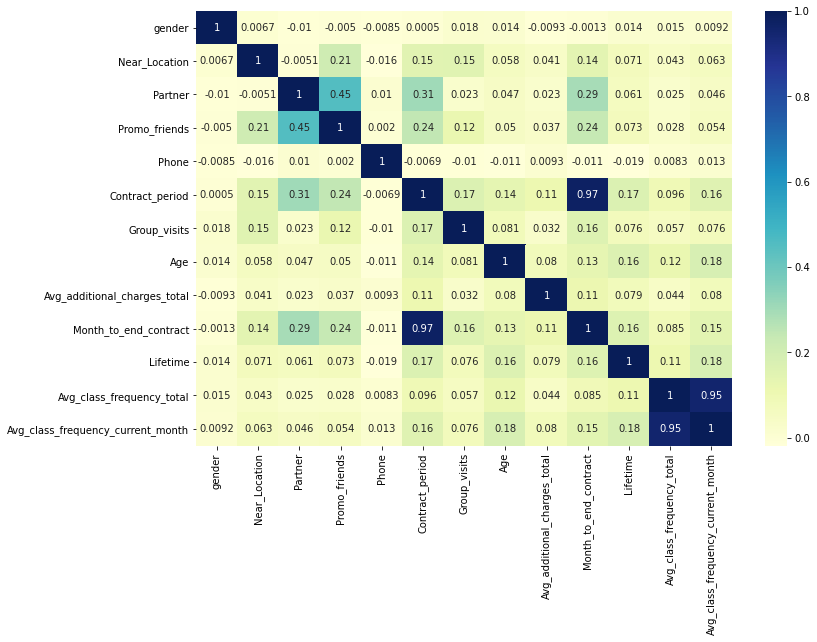

In [10]:
# Посмотрим на матрицу корреляций признаков
plt.figure(figsize=(12,8))
sns.heatmap(df.drop('Churn',axis=1).corr(), annot=True, cmap="YlGnBu");

In [11]:
df.count()

gender                               4000
Near_Location                        4000
Partner                              4000
Promo_friends                        4000
Phone                                4000
Contract_period                      4000
Group_visits                         4000
Age                                  4000
Avg_additional_charges_total         4000
Month_to_end_contract                4000
Lifetime                             4000
Avg_class_frequency_total            4000
Avg_class_frequency_current_month    4000
Churn                                4000
dtype: int64

Видим, что для двух пар признаков (Avg_class_frequency_current_month и Avg_class_frequency_total, Contract_period и Month_to_end_contract) наблюдется сильная скоррелированность. Будем учитывать данный факт при обучении линейной модели. Корреляция для других признаков слабая - в пределах 0.5

## Построим модель прогнозирования оттока клиентов

Бдуем строить модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

In [12]:
# создадим датафрейм X с признаками и датафрейм y с целевой перменной 
X = df.drop(columns=['Churn'])
y = df['Churn']
# разобьем на обучающую и валидационную выборку
X_train, X_test, y_train , y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# стандартизируем признаки 
scaler = StandardScaler()
X_train_st = scaler.fit_transform(
    X_train
) 

X_test_st = scaler.transform(X_test)


# т.к. наблюдается скоррелированность некоторых признаков, 
# для избежания мультиколлинеарности зададим l1-регуляризацию для логистической регрессии 
model_lr = LogisticRegression(penalty='l1', solver = 'liblinear', random_state=42)

# для случайного леса оставим параметры по умолчанию
model_rf = RandomForestClassifier(random_state=42)

# также построим модель классификации с помощью градиентного бустинга
model_gb = GradientBoostingClassifier(random_state=42)

models= [model_lr, model_rf, model_gb]

# функция, которая обучает модель и считает метрики на валидационной выборке
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    print(
        'Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nROC-AUC: {:.3f} \n'.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            roc_auc_score(y_test, y_pred_prob[:,1]),
        )
    )

# к каждой из моделей применим функцию
for m in models:
    print('Метрики для модели', m, ':')
    make_prediction(m, X_train, y_train, X_test, y_test)


Метрики для модели LogisticRegression(penalty='l1', random_state=42, solver='liblinear') :
Accuracy: 0.917
Precision: 0.878
Recall: 0.782
ROC-AUC: 0.969 

Метрики для модели RandomForestClassifier(random_state=42) :
Accuracy: 0.910
Precision: 0.849
Recall: 0.782
ROC-AUC: 0.961 

Метрики для модели GradientBoostingClassifier(random_state=42) :
Accuracy: 0.924
Precision: 0.885
Recall: 0.802
ROC-AUC: 0.971 



Видим, что все три построенные модели очень хорошо справляются с бинарной классификацией клиентов. ROC-AUC для каждой из моделей приближается к 1. Если ранжировать модели по точности прогноза сначала идет градиентный бустинг, затем логистическая регрессия и хуже всего справляется случайный лес. Очень хорошо, что простая модель логистической регрессии в конкретном случе демонстрирует результаты прогноза, близкие к такой сильной модели, как градиентный бустинг.  Для градиентого бустинга можем дополнительно найти наиболее оптимальную комбинацию гиперпараметров, чтобы повысить точность классификации. Воспользуемся RandomizedSearchCV.

In [13]:
%%time
# зададим списки гиперпараметров, которые будут рандомно перебираться
n_estimators = [300, 400, 500]
max_depth = [4, 5, 6]
learning_rate = [0.025, 0.05, 0.1]
min_samples_leaf = [5, 10, 20]

hyperF = dict(
            n_estimators = n_estimators, 
            max_depth = max_depth, 
            learning_rate = learning_rate,
            min_samples_leaf = min_samples_leaf
            )
# воспользуемся классом для рандомного поиска гиперпараметров RandomizedSearchCV из библиотеки sklearn
gridF = RandomizedSearchCV(
                        GradientBoostingClassifier(random_state=42),
                        hyperF, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs = -1, 
                        random_state=42,
                        scoring='roc_auc'
)
                    
bestF = gridF.fit(X_train, y_train)
best_params  = gridF.best_params_
print('Оптимальные гиперпараметры градиентного бустинга:', best_params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Оптимальные гиперпараметры градиентного бустинга: {'n_estimators': 400, 'min_samples_leaf': 10, 'max_depth': 4, 'learning_rate': 0.05}
CPU times: user 55.5 s, sys: 427 ms, total: 55.9 s
Wall time: 57 s


In [14]:
# обучаем бустинг с оптимальными гиперпараметрами и считаем метрики
model = GradientBoostingClassifier(**best_params, random_state=42)
model.fit(X_train, y_train)
model_prediction = model.predict(X_test)
model_prob = model.predict_proba(X_test)

print('Метрики для градиентного бустинга c оптимальными гиперпараметрами:')
make_prediction(model, X_train, y_train, X_test, y_test)


Метрики для градиентного бустинга c оптимальными гиперпараметрами:
Accuracy: 0.935
Precision: 0.899
Recall: 0.837
ROC-AUC: 0.975 



Отлично, метрики растут, ROC_AUC еще сильней приблизился к значению 1. 

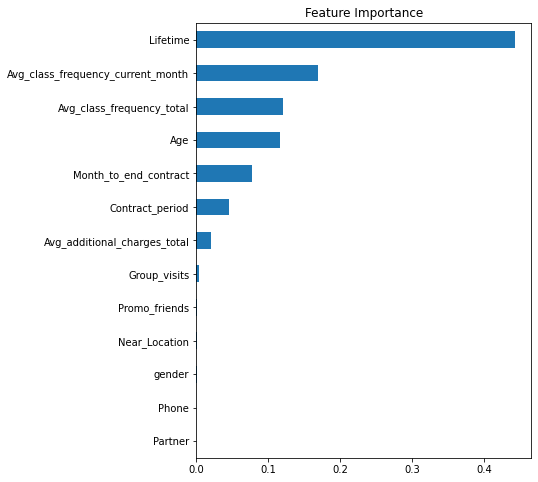

In [15]:
# Посмотрим на важность признаков для бустинга, построим соответствующий плот

plt.rcParams["figure.figsize"] = (6, 8)

X_train.columns

importances = pd.Series(
    model_gb.feature_importances_, index=X_train.columns
).sort_values(ascending=True)
ax = importances.plot.barh() 
ax.set_title("Feature Importance");


Как и предполагалось ранее, наиболее важными признаками в данном случае ялвяются те, по которым наблюдалось наилучшее разделение между модальными значениями гистограмм

## Сделаем кластеризацию клиентов

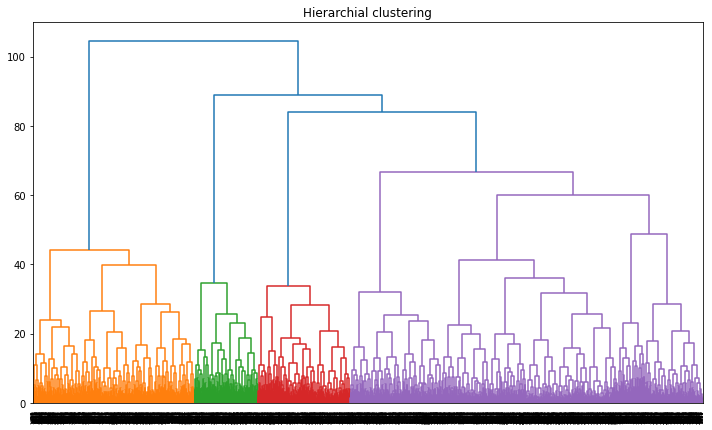

CPU times: user 1min 32s, sys: 20.3 s, total: 1min 52s
Wall time: 1min 53s


In [16]:
%%time
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(df.drop(columns='Churn'))

# построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму.
linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(12, 7))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering')
plt.show() 

На основании дендрограммы иерархической кластеризации, в зависимости от порога расстояния, можно выделить примерно 4 - 6 кластеров объектов

In [17]:
# обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. 
# зададим количество классов 5

km = KMeans(n_clusters=5, random_state=42) 
labels = km.fit_predict(X_sc)

In [18]:
# посмотрим на средние значения признаков для кластеров. 
df['kmeans_labels'] = labels
df.drop('Churn', axis=1).groupby('kmeans_labels').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
kmeans_labels,,,,,,,,,,,,,
0,0.502370,0.949447,0.829384,0.998420,1.0,3.097946,0.448657,29.104265,141.774331,2.887836,3.772512,1.770536,1.669581
1,0.554556,0.849269,0.263217,0.052868,1.0,2.606299,0.436445,30.008999,159.774265,2.419573,4.780652,2.745505,2.733173
2,0.499422,0.937572,0.737572,0.478613,1.0,11.854335,0.546821,29.905202,163.509804,10.812717,4.677457,2.006405,1.998179
3,0.485738,0.718011,0.299919,0.018745,1.0,1.914425,0.276284,28.083945,129.496414,1.821516,2.195599,1.225192,0.967967
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967


Каких-то закономерностей на основе средних значений признаков для кластеров не наблюдается

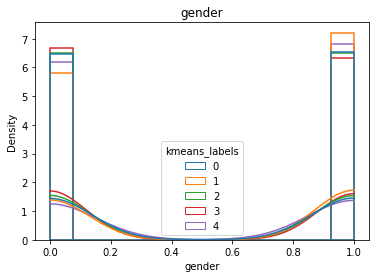

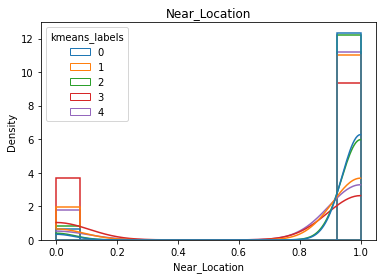

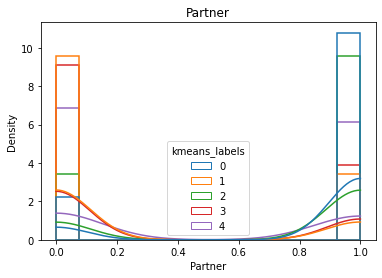

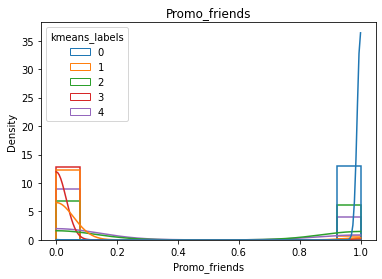

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


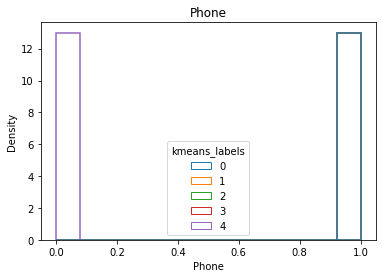

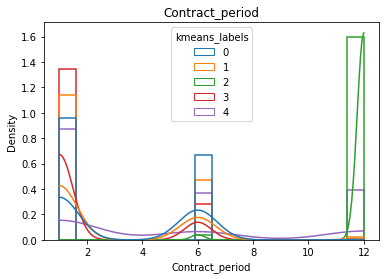

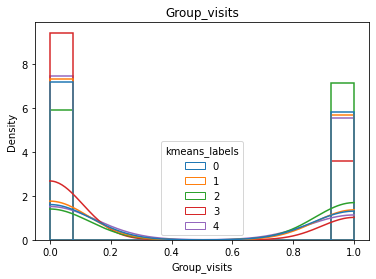

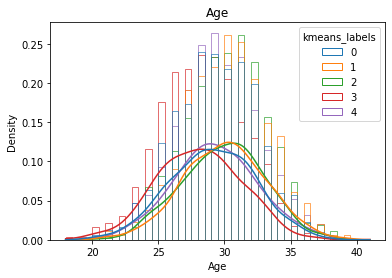

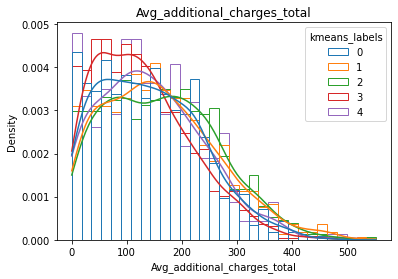

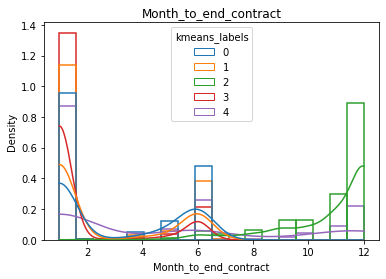

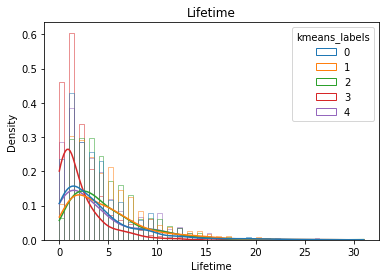

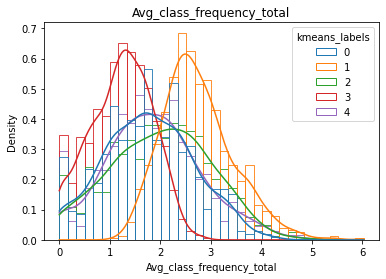

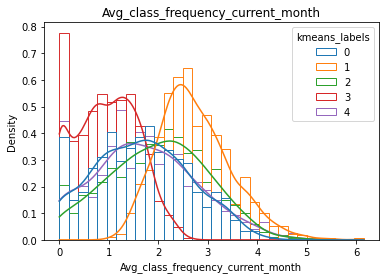

In [19]:
# посмотрим распределения признаков для кластеров. Построим гистограммы 
plt.rcParams["figure.figsize"] = (6, 4)

palette ={0: "C0", 1: "C1", 2: "C2", 3: "C3", 4: 'C4'}

for col in df.columns.drop(['Churn','kmeans_labels']):
    sns.histplot(df,
            x=col, 
            hue = 'kmeans_labels', 
            kde = True, 
            stat="density", 
            fill=False, 
            common_norm=False,
            palette=palette
    )
    plt.title(col)
    plt.show()


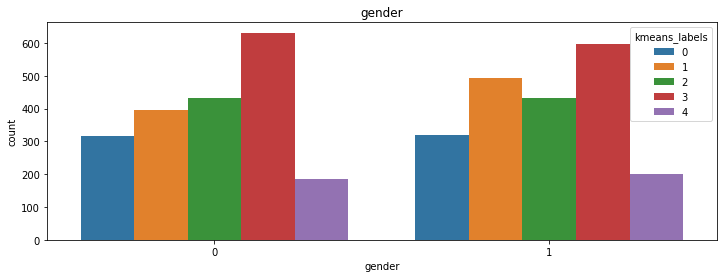

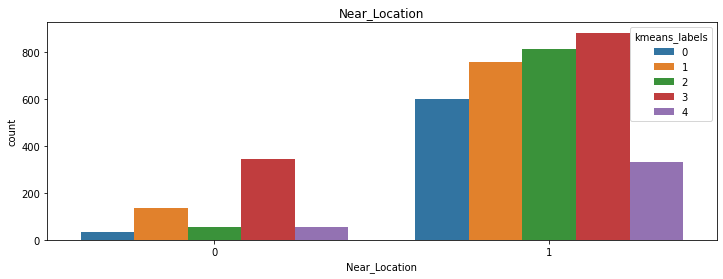

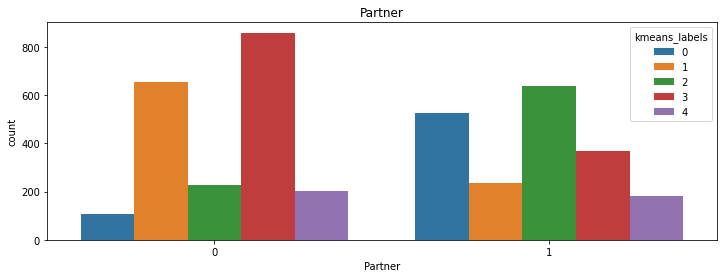

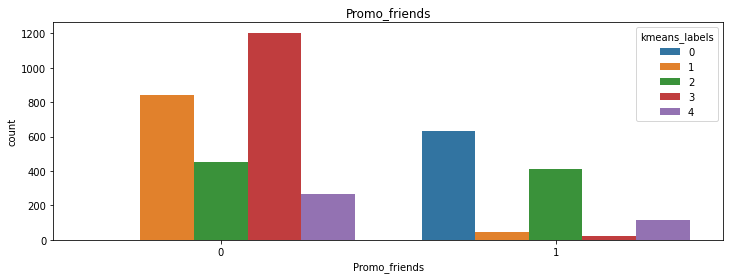

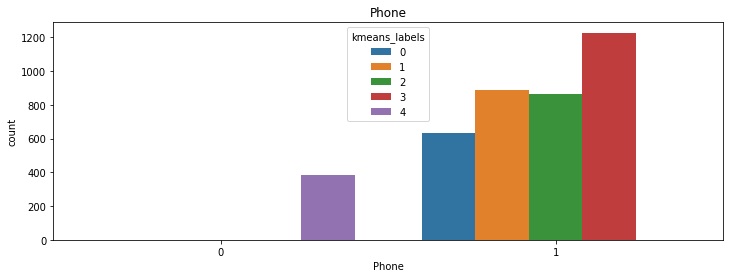

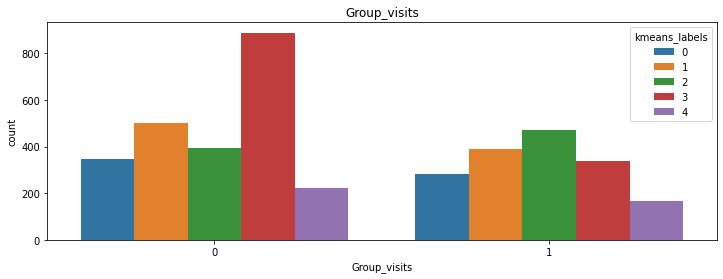

In [20]:
categorical_columns = ['gender','Near_Location','Partner','Promo_friends','Phone','Group_visits']

for column in categorical_columns:
    plt.figure(figsize=(12, 4))
    sns.countplot(x=df[column], hue="kmeans_labels", data=df)
    plt.title(column)
    plt.show()

По распределениям признаков для пяти кластеров можно заметить, что по некоторым непрерывным признакам гистограммы для кластеров "3" и "1" хорошо разделяются - это наиболее "яркие" группы клиентов. Для других трех кластеров по этим же признакам наблюдается полное перекрытие. Можно предположить, что клиенты, относящиеся к кластеру "3" - это наиболее рискованная группа - те, кто с наибольшей вероятностью уйдут в отток. Относящиеся к кластеру "1"  - наоборот, пользователи, которые хорошо удерживаются. Также есть три промежуточные группы: "0", "2" и "4", над удержанием которых следует поработать.

In [21]:
# для каждого полученного кластера посчитеаем долю оттока 
df.groupby('kmeans_labels').Churn.mean()

kmeans_labels
0    0.246445
1    0.089989
2    0.021965
3    0.572942
4    0.266839
Name: Churn, dtype: float64

Анализ кластеров по доле оттока частично подверждает предположения о том, что клиенты, относящиеся к кластеру "3" - это наиболее рискованная группа - те, кто с наибольшей вероятностью уйдут в отток. Наименьшая доля оттока у кластеров "1" и "2". 

Таким образом, можно заключить, что кластеры клиентов "1" и "2" наиболее надежные. Кластер "3" - самый рискованный, его клиенты весьма вероятно уйдут. Клиенты кластеров "0" и "4" находятся в промежуточном состоянии.

## Выводы

- Были построены модели  бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. Были протестированы модели логистической регресии, случайного леса и градиентного бустинга. Было показано, что все три построенные модели очень хорошо справляются с бинарной классификацией клиентов. ROC-AUC для каждой из моделей приближается к 1. Если ранжировать модели по точности прогноза сначала идет градиентный бустинг, затем логистическая регрессия и хуже всего справляется случайный лес. Чтобы повысить предиктивную способность, для градиентого бустинга была найдена оптимальная комбинация гиперпараметров.
- Наиболее важными признаками, сильно влияющими на отток в данном случае ялвяются 'Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month', 'Age'
- Была выполнена кластеризация клиентов с помощью иерархической кластеризаци, а также алгоритма k-средних. На основании дендрограммы иерархической кластеризации, в зависимости от порога расстояния, явно выделяются примерно 4 - 6 кластеров объектов
- По распределениям признаков для пяти (полученные с помощью алгоритма k-средних) кластеров можно заметить, что по некоторым непрерывным признакам гистограммы для кластеров "3" и "1" хорошо разделяются - это наиболее "яркие" группы клиентов. Для других трех кластеров по этим же признакам наблюдается полное перекрытие.
- Анализ кластеров по доле оттока показал, что клиенты, относящиеся к кластеру "3" - это наиболее рискованная группа - те, кто с наибольшей вероятностью уйдут в отток. Наименьшая доля оттока у кластеров "1" и "2".
- Таким образом, можно заключить, что кластеры клиентов "1" и "2" наиболее надежные. Кластер "3" - самый рискованный, его клиенты весьма вероятно уйдут. Клиенты кластеров "0" и "4" находятся в промежуточном состоянии.
- В качестве рекомендаций: можно каким-то образом поработать над пользоватеям из кластеров "0" и "4", добиться того, чтобы их параметры 'Lifetime', 'Avg_class_frequency_total' и 'Avg_class_frequency_current_month' приблизились к этим же параметрам клиентам кластера "1". Далее, снизив риск для указанных групп, можно переходить к повышению удержания самых проблемных клиентов из кластера "3"


Маркетинговые рекомендации для удержания клиентов:

- усилить вовлеченность действующих клиентов за счет приглашения к участию в групповых тренировках
- активизировать кросс-продажи сопутствующих услуг (фитнес-бар, спортивная экипировка и питание, персональные тренировки и консультации и т.д.)
- графики групповых тренировок строить таким образом, чтобы увеличить частоту посещения клиентами фитнес-клуба без ощущения перетренированности и демотивации
- для клиентов, предпочитающих самостоятельные занятия, разработать систему мониторинга посещаемости, в случае падения интереса - систему напоминаний, мотивационных пуш-уведомлений и т.д.